# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Reza Vahidimajd

*SID:* 99102491

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # TODO
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # undo the normalization
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [ ]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:13<00:00, 12670493.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = random_split(initial_trainset, [train_size, val_size])

In [ ]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

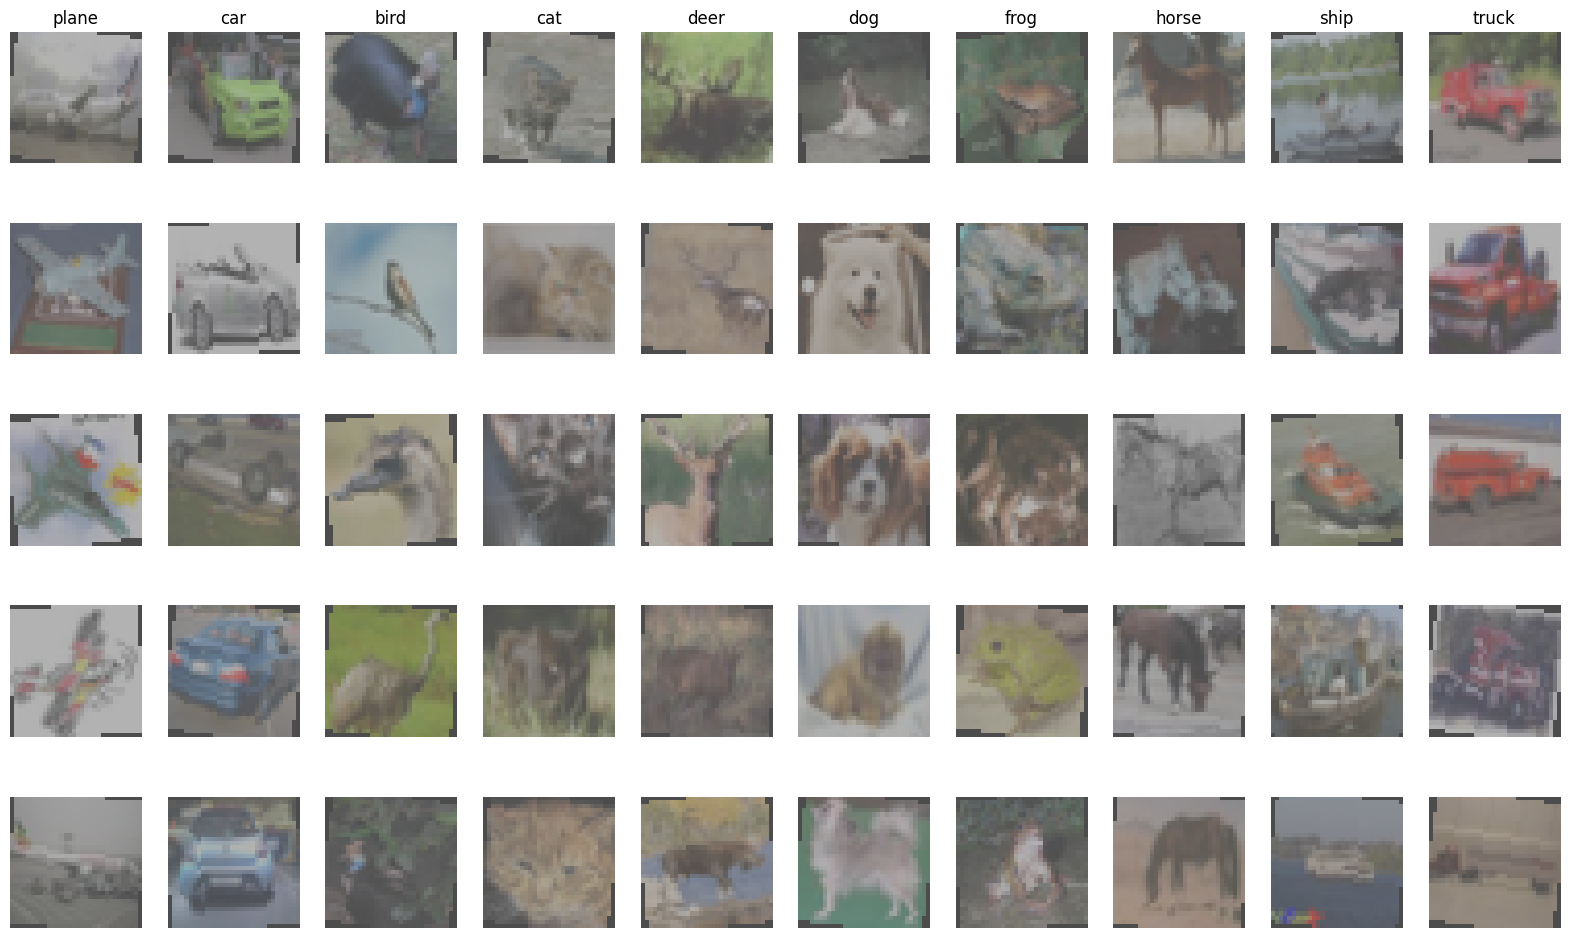

In [ ]:
# TODO

import matplotlib.pyplot as plt
import numpy as np

def collect_indices(dataset, num_classes=10):
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    return class_indices

def display_class_images(dataset, class_indices, num_examples=5, num_classes=10):
    fig, axes = plt.subplots(num_examples, num_classes, figsize=(20, 12))
    for class_idx in range(num_classes):
        chosen_indices = np.random.choice(class_indices[class_idx], num_examples, replace=False)
        for i, idx in enumerate(chosen_indices):
            image, _ = dataset[idx]
            ax = axes[i, class_idx]
            ax.imshow(norminv(image).permute(1, 2, 0).numpy())
            ax.axis('off')
            if i == 0:
                ax.set_title(classes[class_idx])
    plt.show()

indices_per_class = collect_indices(trainset)
display_class_images(trainset, indices_per_class)



## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1000)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18()
net = net.to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
from time import time

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

def train_epoch(net, criterion, optimizer, scheduler, dataloader):
    net.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm.tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    scheduler.step()
    train_loss = running_loss / total
    train_accuracy = correct / total
    return train_loss, train_accuracy

def eval_epoch(net, criterion, dataloader, test_mode=False):
    net.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / total
    val_accuracy = correct / total
    return val_loss, val_accuracy

In [ ]:
epochs = 30

for e in range(epochs):
    start_time = time()
    train_loss, train_accuracy = train_epoch(net, criterion, optimizer, scheduler, trainloader)
    val_loss, val_accuracy = eval_epoch(net, criterion, valloader, test_mode=False)

    print(f'Epoch {e+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Time taken for epoch {e+1}: {time() - start_time:.2f} seconds\n')

100%|██████████| 157/157 [00:05<00:00, 27.51it/s]


Epoch 1:
Train Loss: 1.5111, Train Accuracy: 0.4621
Validation Loss: 1.2852, Validation Accuracy: 0.5421
Time taken for epoch 1: 36.94 seconds



100%|██████████| 157/157 [00:05<00:00, 27.86it/s]


Epoch 2:
Train Loss: 1.1397, Train Accuracy: 0.5990
Validation Loss: 1.0394, Validation Accuracy: 0.6400
Time taken for epoch 2: 35.06 seconds



100%|██████████| 157/157 [00:05<00:00, 28.08it/s]


Epoch 3:
Train Loss: 0.9806, Train Accuracy: 0.6562
Validation Loss: 0.9187, Validation Accuracy: 0.6789
Time taken for epoch 3: 34.70 seconds



100%|██████████| 157/157 [00:05<00:00, 30.23it/s]


Epoch 4:
Train Loss: 0.8691, Train Accuracy: 0.6974
Validation Loss: 0.8838, Validation Accuracy: 0.6911
Time taken for epoch 4: 34.84 seconds



100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch 5:
Train Loss: 0.7959, Train Accuracy: 0.7241
Validation Loss: 0.8362, Validation Accuracy: 0.7131
Time taken for epoch 5: 39.78 seconds



100%|██████████| 157/157 [00:05<00:00, 28.82it/s]


Epoch 6:
Train Loss: 0.7362, Train Accuracy: 0.7454
Validation Loss: 0.8161, Validation Accuracy: 0.7225
Time taken for epoch 6: 34.49 seconds



100%|██████████| 157/157 [00:05<00:00, 28.42it/s]


Epoch 7:
Train Loss: 0.6837, Train Accuracy: 0.7611
Validation Loss: 0.7722, Validation Accuracy: 0.7409
Time taken for epoch 7: 35.96 seconds



100%|██████████| 157/157 [00:05<00:00, 29.71it/s]


Epoch 8:
Train Loss: 0.6439, Train Accuracy: 0.7757
Validation Loss: 0.7276, Validation Accuracy: 0.7542
Time taken for epoch 8: 34.69 seconds



100%|██████████| 157/157 [00:04<00:00, 31.92it/s]


Epoch 9:
Train Loss: 0.5954, Train Accuracy: 0.7954
Validation Loss: 0.7113, Validation Accuracy: 0.7610
Time taken for epoch 9: 34.47 seconds



100%|██████████| 157/157 [00:04<00:00, 31.53it/s]


Epoch 10:
Train Loss: 0.5635, Train Accuracy: 0.8054
Validation Loss: 0.7206, Validation Accuracy: 0.7530
Time taken for epoch 10: 34.74 seconds



100%|██████████| 157/157 [00:04<00:00, 31.99it/s]


Epoch 11:
Train Loss: 0.5303, Train Accuracy: 0.8154
Validation Loss: 0.6933, Validation Accuracy: 0.7677
Time taken for epoch 11: 34.56 seconds



100%|██████████| 157/157 [00:05<00:00, 31.22it/s]


Epoch 12:
Train Loss: 0.4984, Train Accuracy: 0.8271
Validation Loss: 0.6755, Validation Accuracy: 0.7704
Time taken for epoch 12: 35.70 seconds



100%|██████████| 157/157 [00:05<00:00, 29.53it/s]


Epoch 13:
Train Loss: 0.4634, Train Accuracy: 0.8406
Validation Loss: 0.7063, Validation Accuracy: 0.7678
Time taken for epoch 13: 34.91 seconds



100%|██████████| 157/157 [00:05<00:00, 27.64it/s]


Epoch 14:
Train Loss: 0.4351, Train Accuracy: 0.8495
Validation Loss: 0.6941, Validation Accuracy: 0.7755
Time taken for epoch 14: 35.01 seconds



100%|██████████| 157/157 [00:05<00:00, 28.08it/s]


Epoch 15:
Train Loss: 0.4059, Train Accuracy: 0.8560
Validation Loss: 0.7229, Validation Accuracy: 0.7669
Time taken for epoch 15: 35.05 seconds



100%|██████████| 157/157 [00:05<00:00, 28.40it/s]


Epoch 16:
Train Loss: 0.3930, Train Accuracy: 0.8621
Validation Loss: 0.6726, Validation Accuracy: 0.7843
Time taken for epoch 16: 34.77 seconds



100%|██████████| 157/157 [00:05<00:00, 30.01it/s]


Epoch 17:
Train Loss: 0.3498, Train Accuracy: 0.8782
Validation Loss: 0.7285, Validation Accuracy: 0.7761
Time taken for epoch 17: 34.62 seconds



100%|██████████| 157/157 [00:04<00:00, 31.64it/s]


Epoch 18:
Train Loss: 0.3448, Train Accuracy: 0.8787
Validation Loss: 0.6944, Validation Accuracy: 0.7843
Time taken for epoch 18: 34.35 seconds



100%|██████████| 157/157 [00:04<00:00, 32.50it/s]


Epoch 19:
Train Loss: 0.3165, Train Accuracy: 0.8911
Validation Loss: 0.6859, Validation Accuracy: 0.7886
Time taken for epoch 19: 34.42 seconds



100%|██████████| 157/157 [00:04<00:00, 32.08it/s]


Epoch 20:
Train Loss: 0.2966, Train Accuracy: 0.8972
Validation Loss: 0.7002, Validation Accuracy: 0.7887
Time taken for epoch 20: 35.38 seconds



100%|██████████| 157/157 [00:04<00:00, 31.89it/s]


Epoch 21:
Train Loss: 0.2775, Train Accuracy: 0.9028
Validation Loss: 0.7660, Validation Accuracy: 0.7759
Time taken for epoch 21: 37.40 seconds



100%|██████████| 157/157 [00:04<00:00, 31.90it/s]


Epoch 22:
Train Loss: 0.2700, Train Accuracy: 0.9065
Validation Loss: 0.7659, Validation Accuracy: 0.7759
Time taken for epoch 22: 34.83 seconds



100%|██████████| 157/157 [00:04<00:00, 31.62it/s]


Epoch 23:
Train Loss: 0.2460, Train Accuracy: 0.9133
Validation Loss: 0.7513, Validation Accuracy: 0.7847
Time taken for epoch 23: 34.58 seconds



100%|██████████| 157/157 [00:05<00:00, 29.80it/s]


Epoch 24:
Train Loss: 0.2304, Train Accuracy: 0.9192
Validation Loss: 0.7803, Validation Accuracy: 0.7765
Time taken for epoch 24: 35.01 seconds



100%|██████████| 157/157 [00:05<00:00, 28.30it/s]


Epoch 25:
Train Loss: 0.2202, Train Accuracy: 0.9222
Validation Loss: 0.7921, Validation Accuracy: 0.7809
Time taken for epoch 25: 34.93 seconds



100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


Epoch 26:
Train Loss: 0.2149, Train Accuracy: 0.9251
Validation Loss: 0.7662, Validation Accuracy: 0.7870
Time taken for epoch 26: 34.91 seconds



100%|██████████| 157/157 [00:05<00:00, 28.61it/s]


Epoch 27:
Train Loss: 0.1926, Train Accuracy: 0.9334
Validation Loss: 0.8314, Validation Accuracy: 0.7815
Time taken for epoch 27: 34.75 seconds



100%|██████████| 157/157 [00:05<00:00, 26.60it/s]


Epoch 28:
Train Loss: 0.1942, Train Accuracy: 0.9330
Validation Loss: 0.8379, Validation Accuracy: 0.7715
Time taken for epoch 28: 35.29 seconds



100%|██████████| 157/157 [00:04<00:00, 32.02it/s]


Epoch 29:
Train Loss: 0.1853, Train Accuracy: 0.9351
Validation Loss: 0.8234, Validation Accuracy: 0.7848
Time taken for epoch 29: 34.43 seconds



100%|██████████| 157/157 [00:04<00:00, 31.42it/s]

Epoch 30:
Train Loss: 0.1680, Train Accuracy: 0.9421
Validation Loss: 0.8090, Validation Accuracy: 0.7839
Time taken for epoch 30: 35.03 seconds



### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

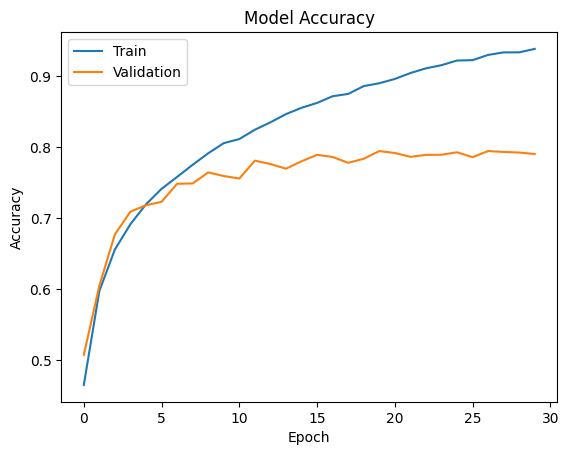

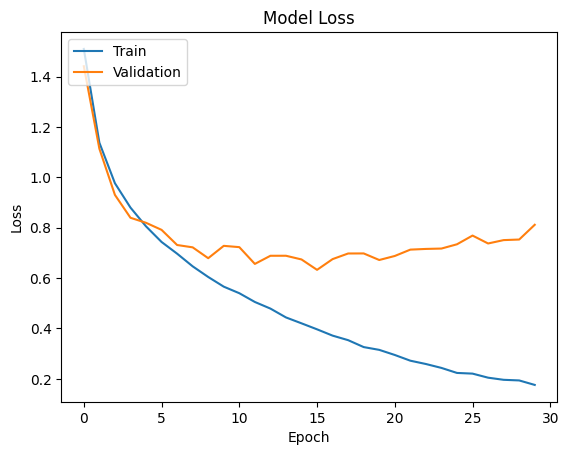

In [ ]:
# TODO
import matplotlib.pyplot as plt

plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
# TODO

net.eval()
running_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in tqdm.tqdm(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
test_loss = running_loss / total
test_accuracy = correct / total
print("\ntest loss: " + str(test_loss))
print("test accuracy: " + str(test_accuracy))

100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


test loss: 0.7470633859634399
test accuracy: 0.8032


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

100%|██████████| 157/157 [00:03<00:00, 41.56it/s]


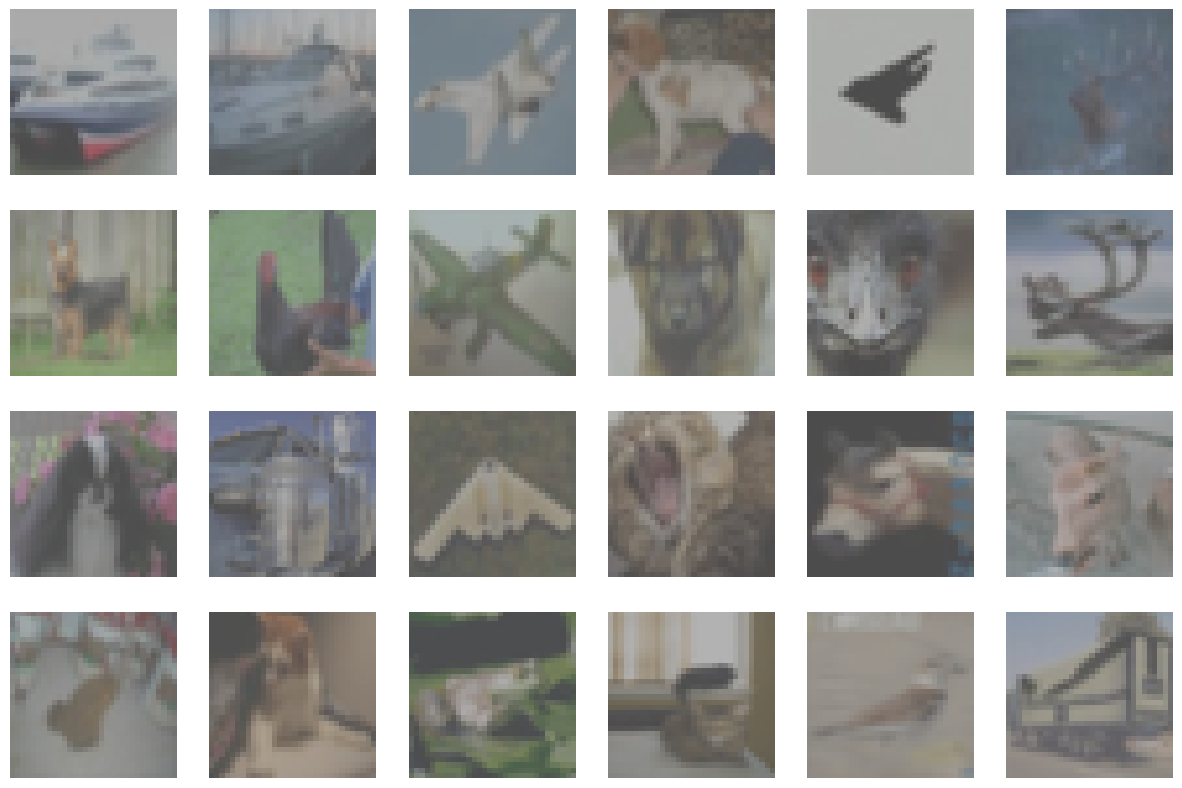

In [ ]:
# TODO
import matplotlib.pyplot as plt

net.eval()

incorrect_preds = []
with torch.no_grad():
    for inputs, labels in tqdm.tqdm(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        for i, x in enumerate(predicted):
            if x != labels[i] and len(incorrect_preds) < 24:
                incorrect_preds.append(inputs[i])



fig, axes = plt.subplots(4, 6, figsize=(15, 10))

for idx, ax in enumerate(axes.ravel()):
    ax.imshow(norminv(incorrect_preds[idx]).permute(1, 2, 0).cpu().numpy())
    ax.axis('off')

plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# TODO


def hook(module, input, output):
    features.extend(input)

net.eval()
features, train_images, train_labels = [], [], []
hook_handle = getattr(net, "fc").register_forward_hook(hook)

with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        _ = net(images)
        train_images.append(images)
        train_labels.append(labels)

hook_handle.remove()
train_features, train_images, train_labels = torch.cat(features), torch.cat(train_images), torch.cat(train_labels)



### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [ ]:
# TODO

def hook(module, input, output):
    features.extend(input)

net.eval()
features = []
hook_handle = getattr(net, "fc").register_forward_hook(hook)

correct_preds = []
with torch.no_grad():
    for n, batch in enumerate(testloader):
        (images, labels) = batch
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = outputs.max(1)
        for i, x in enumerate(predicted):
            if x == labels[i] and len(correct_preds) < 5:
                correct_preds.append([images[i], labels[i], features[n][i]])


hook_handle.remove()

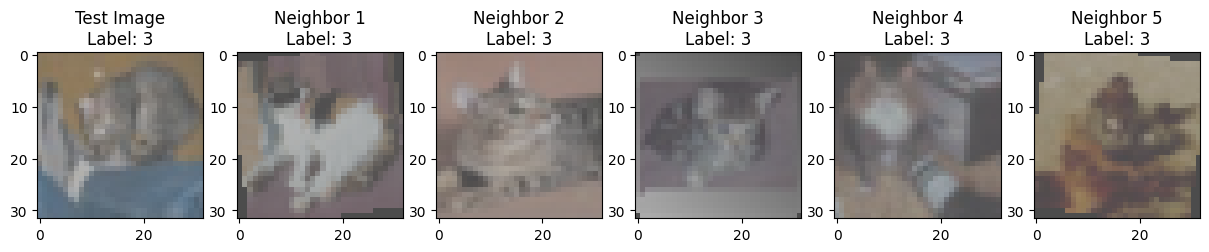

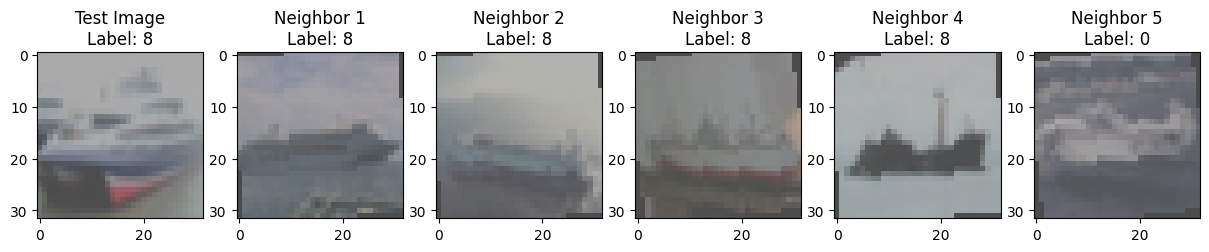

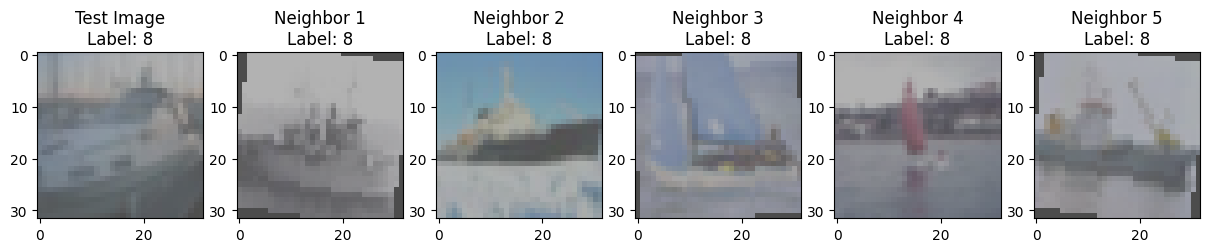

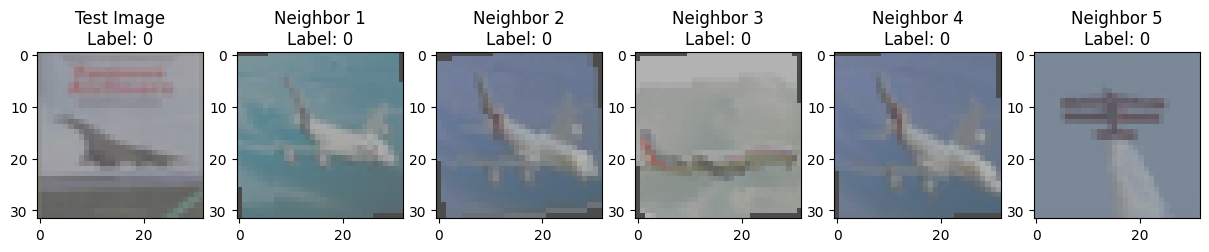

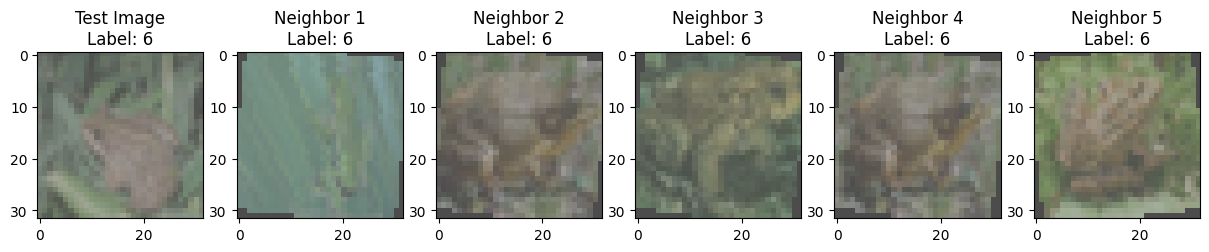

In [ ]:
for i in range(5):
    distances = torch.norm(train_features - correct_preds[i][2], dim=1)
    _, indices = torch.topk(distances, 5, largest=False)
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(norminv(correct_preds[i][0]).permute(1, 2, 0).cpu().numpy())
    plt.title(f"Test Image\nLabel: {correct_preds[i][1]}")

    for i, index in enumerate(indices):
        plt.subplot(1, 6, i+2)
        plt.imshow(norminv(train_images[index]).permute(1, 2, 0).cpu().numpy())
        plt.title(f"Neighbor {i+1}\nLabel: {train_labels[index]}")

    plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


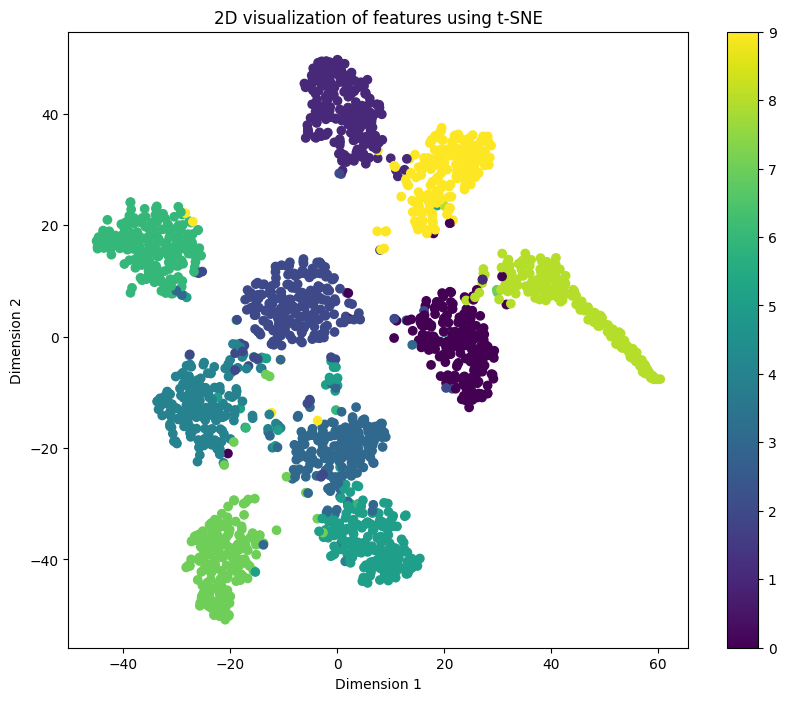

In [ ]:
# TODO

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

M = 2000
indices = np.random.choice(train_features.shape[0], M, replace=False)
X_sampled = train_features[indices]
y_sampled = train_labels[indices]

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sampled.cpu().numpy())

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sampled.cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D visualization of features using t-SNE')
plt.show()


# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [4]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
from PIL import Image


class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.cifar10 = CIFAR10(root=root, train=train, download=download, transform=transform)
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()
        self.color_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                   transforms.ColorJitter()])

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, index):
        rgb_image, label = self.cifar10[index]

        #bw_image = self.to_pil(self.to_tensor(rgb_image).mean(dim=0, keepdim=True).repeat(3, 1, 1))
        bw_image = self.color_transform(rgb_image)

        return bw_image, rgb_image

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170498071/170498071 [00:06<00:00, 25226866.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [8]:
trainset, valset = torch.utils.data.random_split(initial_trainset, (int(0.8*len(initial_trainset)), len(initial_trainset) - int(0.8*len(initial_trainset))))

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

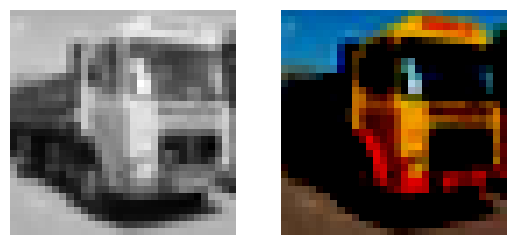

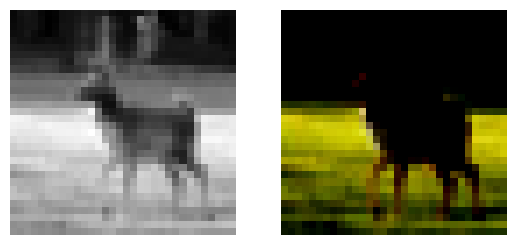

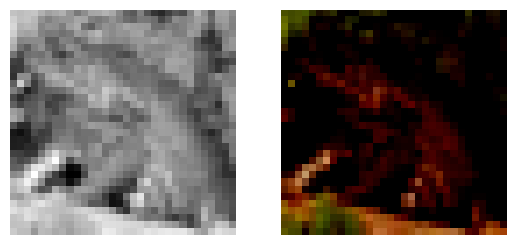

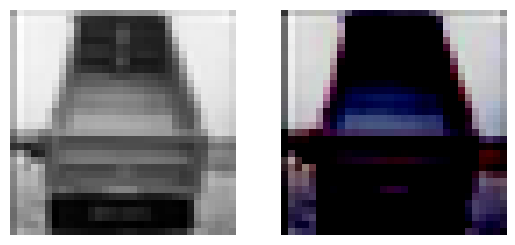

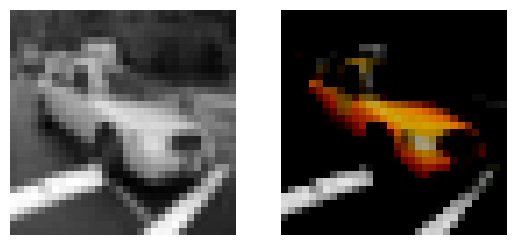

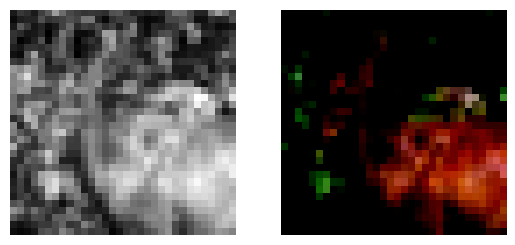

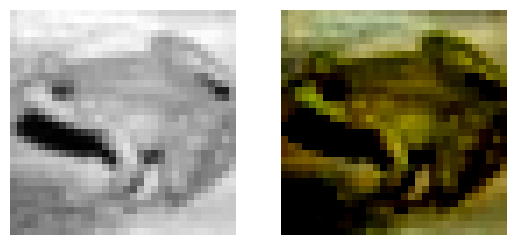

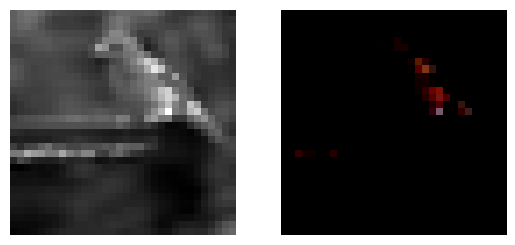

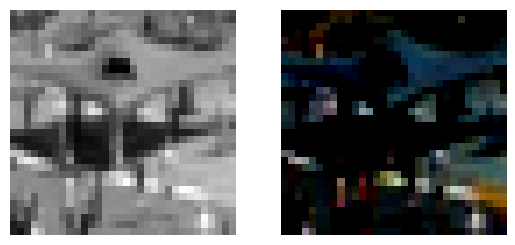

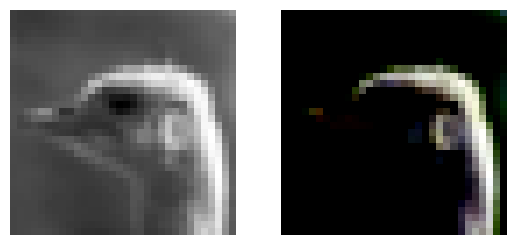

In [10]:
# TODO
import matplotlib.pyplot as plt


for i in range(10):
    bw_img, rgb_img = trainset[i]
    bw_img_np = bw_img.squeeze()
    rgb_img_np = rgb_img.permute(1, 2, 0)

    fig, axarr = plt.subplots(1, 2)
    axarr[0].imshow(bw_img_np, cmap='gray')
    axarr[0].axis('off')
    axarr[1].imshow(rgb_img_np)
    axarr[1].axis('off')
    plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [11]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        return out

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(TransConvBlock, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, skip_input):
        out = self.relu(self.bn(self.transconv(x)))
        out = torch.cat((out, skip_input), dim=1)
        return out

class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = ConvBlock(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.transconv1 = TransConvBlock(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.transconv2 = TransConvBlock(in_channels=512, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.transconv3 = TransConvBlock(in_channels=256, out_channels=64, kernel_size=2, stride=2, padding=0)

        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool(c1)
        c2 = self.conv2(p1)
        p2 = self.pool(c2)
        c3 = self.conv3(p2)
        p3 = self.pool(c3)
        c4 = self.conv4(p3)

        out = self.transconv1(c4, c3)
        out = self.transconv2(out, c2)
        out = self.transconv3(out, c1)

        out = self.final_conv(out)
        return torch.sigmoid(out)

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [12]:
net = ColorizationNet()
net.to(device)

ColorizationNet(
  (conv1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (transconv1): TransConvBlock(
    (tr

In [13]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
import tqdm
from time import time

In [17]:
def train_epoch(net, criterion, optimizer, dataloader):
    net.train()
    running_loss = 0.0
    for data in dataloader:
        bw_image, rgb_image = data
        bw_image, rgb_image = bw_image.to(device), rgb_image.to(device)
        optimizer.zero_grad()

        outputs = net(bw_image)
        loss = criterion(outputs, rgb_image)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

def eval_epoch(net, criterion, dataloader, test_mode=False):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            bw_image, rgb_image = data
            bw_image, rgb_image = bw_image.to(device), rgb_image.to(device)
            outputs = net(bw_image)
            loss = criterion(outputs, rgb_image)
            running_loss += loss.item()

    return running_loss / len(dataloader)

In [18]:
epochs = 20

train_losses = []
val_losses = []

for e in range(epochs):
    train_loss= train_epoch(net, criterion, optimizer, trainloader)
    val_loss = eval_epoch(net, criterion, valloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {e+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/20: Train Loss: 0.1638, Val Loss: 0.1508
Epoch 2/20: Train Loss: 0.1521, Val Loss: 0.1506
Epoch 3/20: Train Loss: 0.1516, Val Loss: 0.1498
Epoch 4/20: Train Loss: 0.1513, Val Loss: 0.1498
Epoch 5/20: Train Loss: 0.1511, Val Loss: 0.1498
Epoch 6/20: Train Loss: 0.1509, Val Loss: 0.1496
Epoch 7/20: Train Loss: 0.1506, Val Loss: 0.1494
Epoch 8/20: Train Loss: 0.1505, Val Loss: 0.1495
Epoch 9/20: Train Loss: 0.1503, Val Loss: 0.1492
Epoch 10/20: Train Loss: 0.1501, Val Loss: 0.1495
Epoch 11/20: Train Loss: 0.1499, Val Loss: 0.1494
Epoch 12/20: Train Loss: 0.1498, Val Loss: 0.1493
Epoch 13/20: Train Loss: 0.1495, Val Loss: 0.1494
Epoch 14/20: Train Loss: 0.1493, Val Loss: 0.1492
Epoch 15/20: Train Loss: 0.1491, Val Loss: 0.1494
Epoch 16/20: Train Loss: 0.1488, Val Loss: 0.1495
Epoch 17/20: Train Loss: 0.1485, Val Loss: 0.1496
Epoch 18/20: Train Loss: 0.1483, Val Loss: 0.1498
Epoch 19/20: Train Loss: 0.1480, Val Loss: 0.1496
Epoch 20/20: Train Loss: 0.1478, Val Loss: 0.1494


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

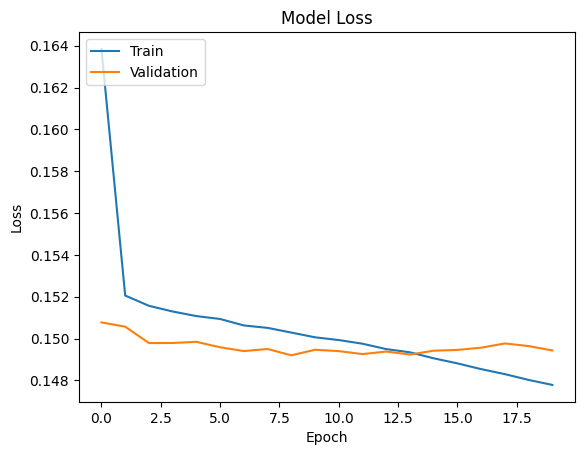

In [19]:
# TODO

import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [38]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

Files already downloaded and verified


In [39]:
# TODO

bw_images = []
gt_images = []
model_outputs = []

for i in range(36):
    bw_img, rgb_img = testset[i]
    bw_images.append(bw_img)
    gt_images.append(rgb_img)


In [40]:
for i in range(36):
  with torch.no_grad():
    output = net(bw_images[i].unsqueeze(0).to(device)).squeeze().cpu()
    model_outputs.append(output)


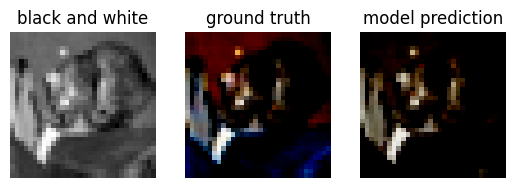

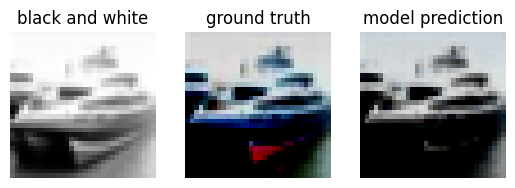

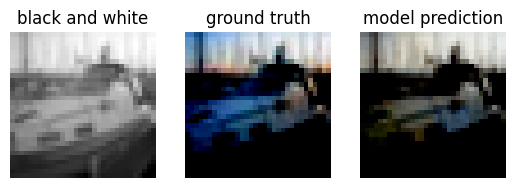

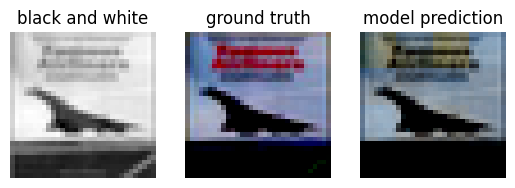

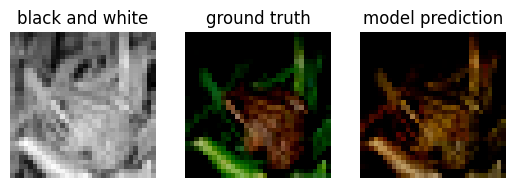

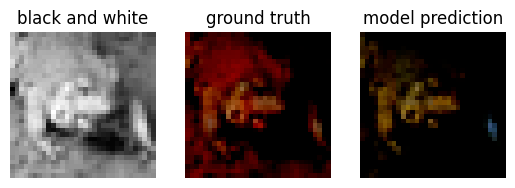

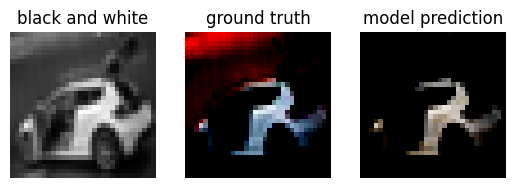

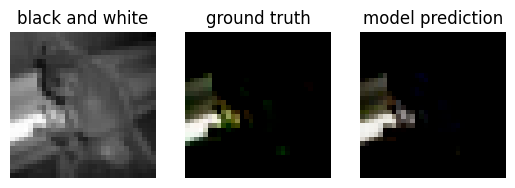

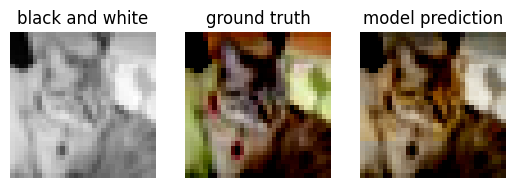

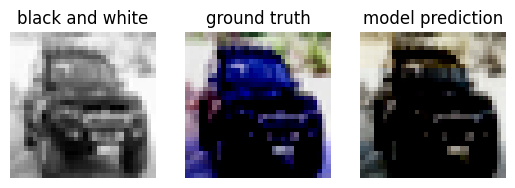

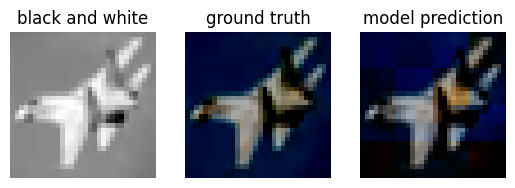

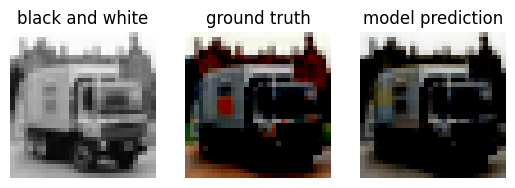

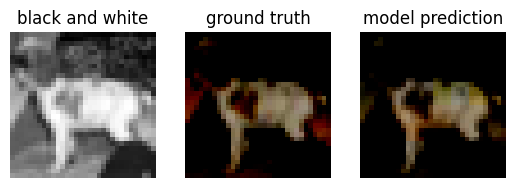

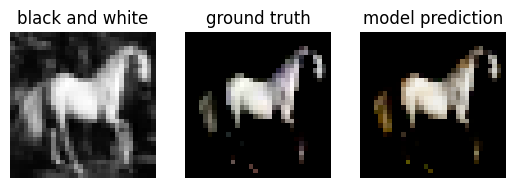

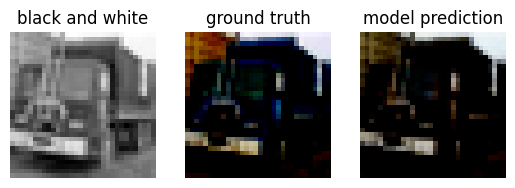

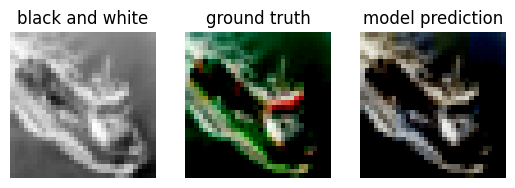

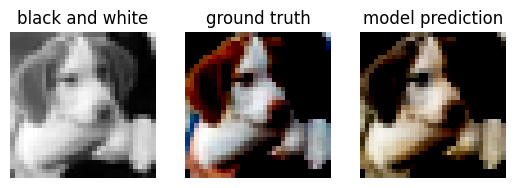

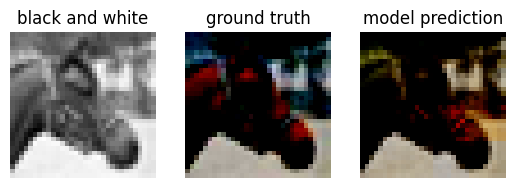

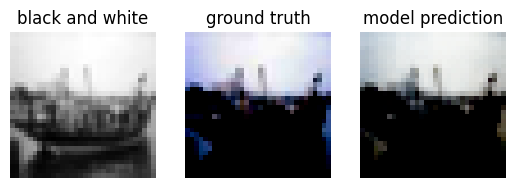

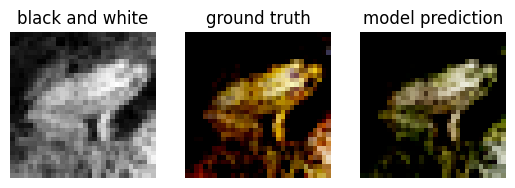

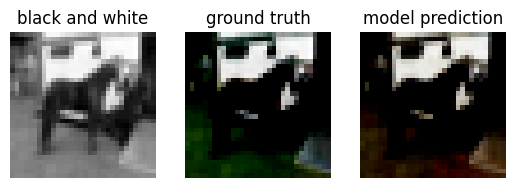

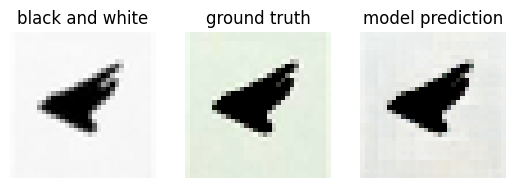

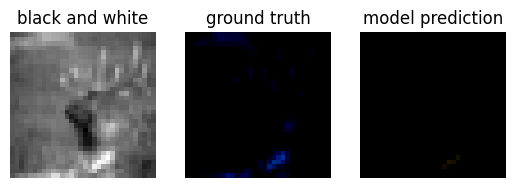

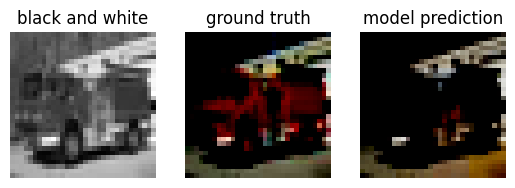

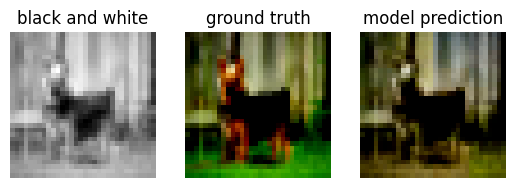

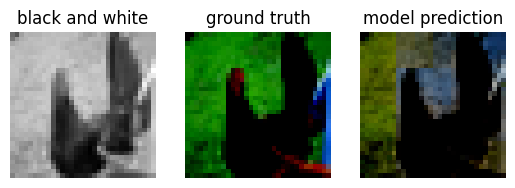

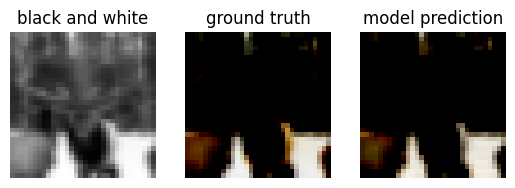

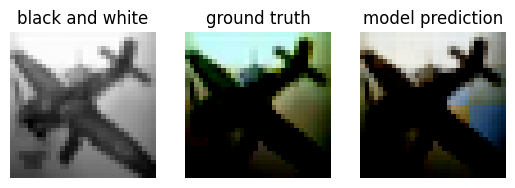

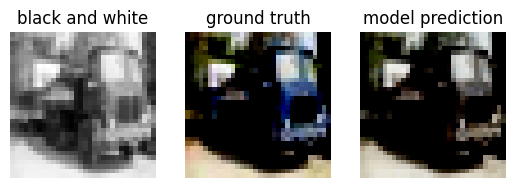

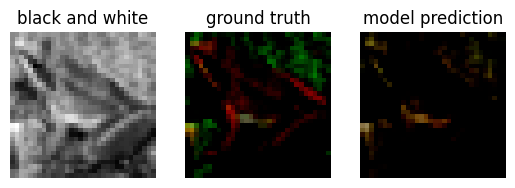

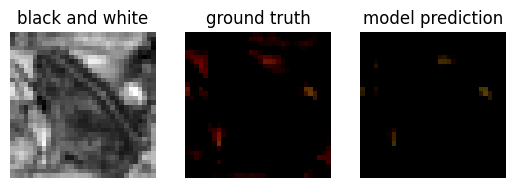

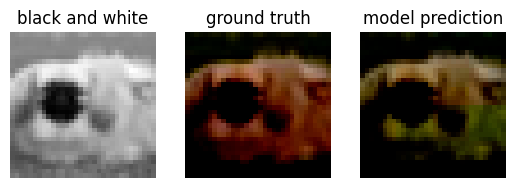

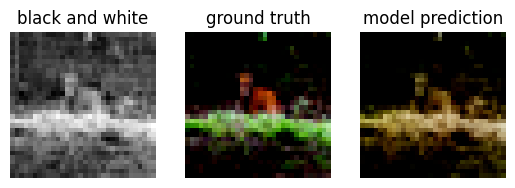

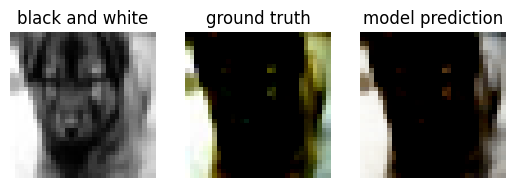

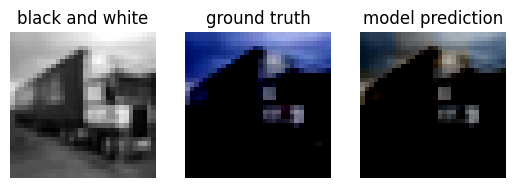

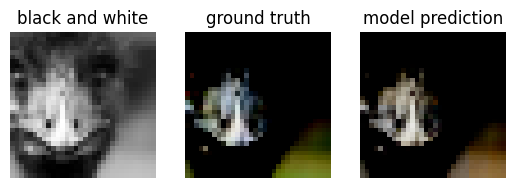

In [43]:
for i in range(36):

    bw_img_np = bw_images[i].squeeze()

    rgb_img_np = gt_images[i].permute(1, 2, 0)

    fig, axarr = plt.subplots(1, 3)
    axarr[0].imshow(bw_img_np, cmap='gray')
    axarr[0].set_title("black and white")
    axarr[0].axis('off')
    axarr[1].imshow(rgb_img_np)
    axarr[1].set_title("ground truth")
    axarr[1].axis('off')
    axarr[2].imshow(model_outputs[i].permute(1, 2, 0))
    axarr[2].set_title("model prediction")
    axarr[2].axis('off')
    plt.show()